Here we show an example of how to use the `contrib.transfer` package to perform evolutionary transfer with a simple "population seeding" method.

# Basic Algorithm

Firt we'll define a basic EA along the usual lines.  But we're going to make it take a `problem` and an `initialize` method as parameters.

This will allow us to reuse the same algorithm code across **different problems** and with arbitrary **population-initialization** strategies:

In [ ]:
from leap.algorithm import generational_ea
from leap import core, ops

def ea(problem, initialize, probes=[], step_notify=[], generations=200):
    """A simple generational EA with tournament_selection selection and Gaussian mutation."""
    pop_size=5
    mutate_std=0.5

    ea = generational_ea(generations=generations, pop_size=pop_size,
                         individual_cls=core.Individual,  # Use the standard Individual as the prototype for the population.
                         decoder=core.IdentityDecoder(),  # Genotype and phenotype are the same for this task.
                         problem=problem,

                         initialize=initialize,

                         # The operator pipeline.
                         pipeline=probes + [
                              ops.tournament_selection,
                              ops.clone,
                              ops.mutate_gaussian(std=mutate_std, hard_bounds=problem.bounds),
                              ops.evaluate,
                              ops.pool(size=pop_size)
                         ])
    return ea

# Source Problems

The spheroid and Rastrigin functions are kind of the "hello world" of evolutionary transfer, because they are obviously similar: the two problems share the same global optima, and the same quadratic macro-structure.

In [2]:
from leap import real_problems

problem1 = real_problems.Spheroid()
problem2 = real_problems.Rastrigin(a=10)

Let's visualize the problems:

<IPython.core.display.Javascript object>


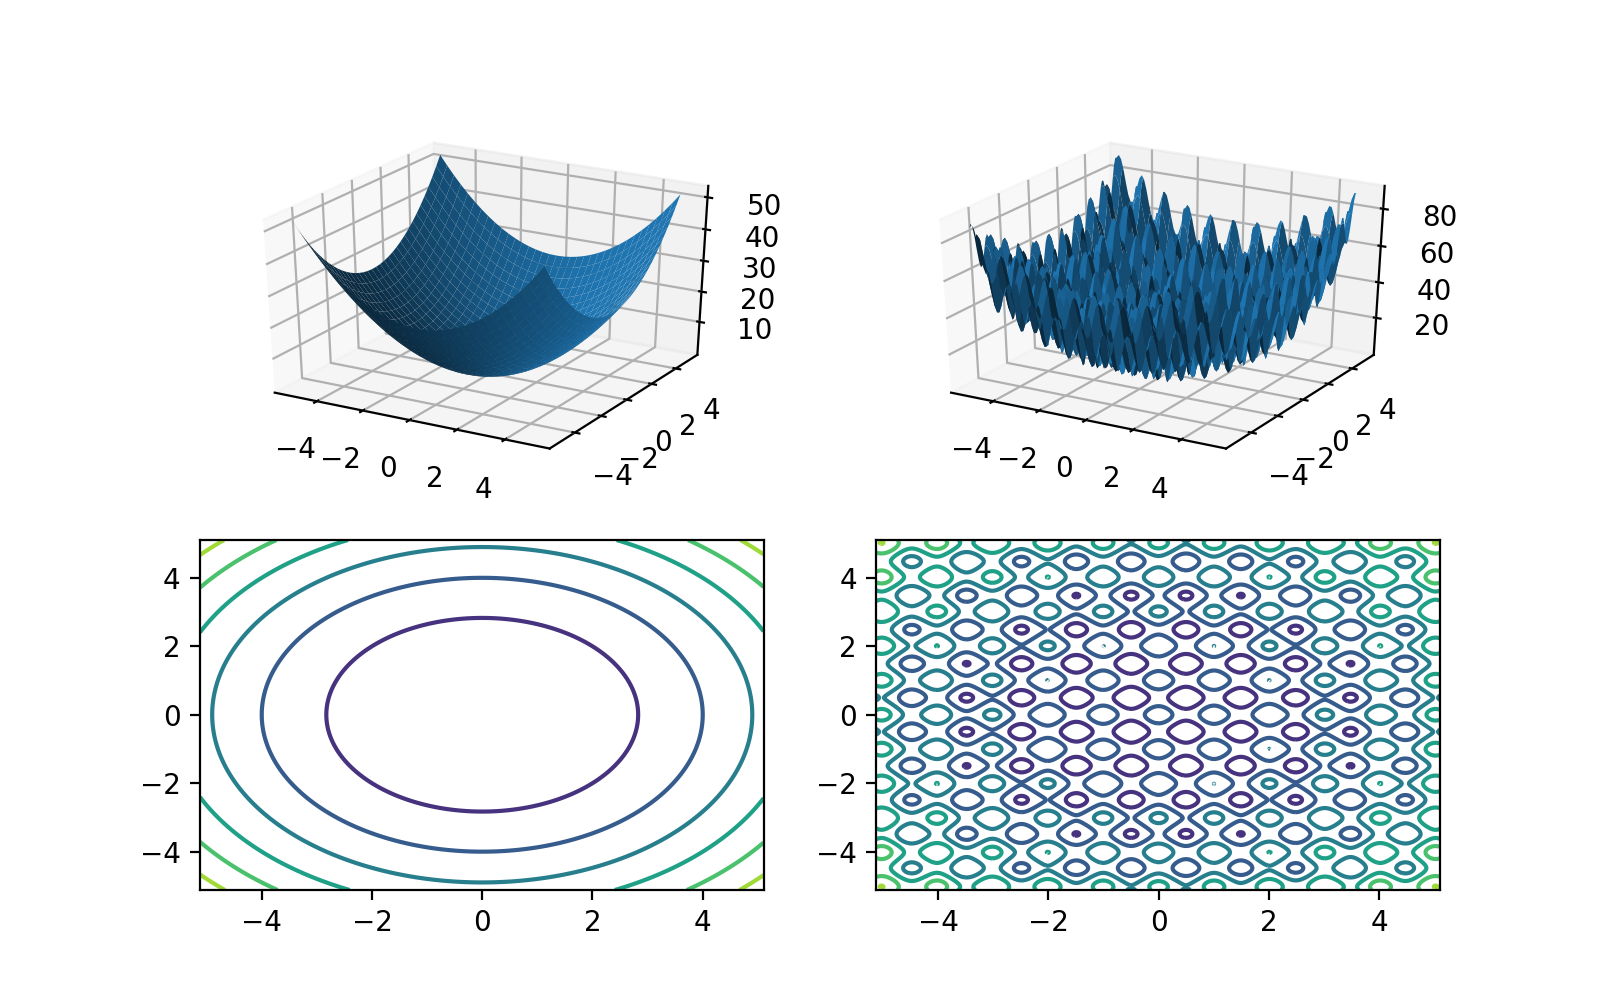

In [3]:
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(8, 5))
plt.subplot(221, projection='3d')
real_problems.plot_2d_problem(problem1, ax=plt.gca(), xlim=problem1.bounds, ylim=problem1.bounds);
plt.subplot(222, projection='3d')
real_problems.plot_2d_problem(problem2, ax=plt.gca(), xlim=problem2.bounds, ylim=problem2.bounds);

plt.subplot(223)
real_problems.plot_2d_problem(problem1, kind='contour', ax=plt.gca(), xlim=problem1.bounds, ylim=problem1.bounds, granularity=0.025);
plt.subplot(224)
real_problems.plot_2d_problem(problem2, kind='contour', ax=plt.gca(), xlim=problem2.bounds, ylim=problem2.bounds, granularity=0.025);

# Building a Repertoire

Let's built a reportoire by running a single-task EA on both of the problems.  We'll be using this class:

In [4]:
from leap.contrib.transfer.sequential import PopulationSeedingRepertoire

The repertoire constructor needs three things:

#### 1. A List of Problems

In [5]:
problems = [problem1, problem2]

#### 2. A Standard Initializer

This should be a function that initializes the population in the usual way (i.e. by generating random individuals):

In [6]:
random_init = core.create_real_vector(bounds=[[-1, 1]] * 2)

#### 3. (OPTIONAL) Problem-Specific Arguments

Often we need to do some additional problem-specific configuration of an algorithm—like inserting a different probe for each problem so that we can independently record metrics.

When building an archive on multiple problems, we accomplish this by building an additional list of `problem_kwargs` to pass in alongside the `problems` list.

For example, here I want each of my algorithms to plot some data to a different plot.  So before we run the `repertoire.build()` method, let's set up some plots to attach probes to:

<IPython.core.display.Javascript object>


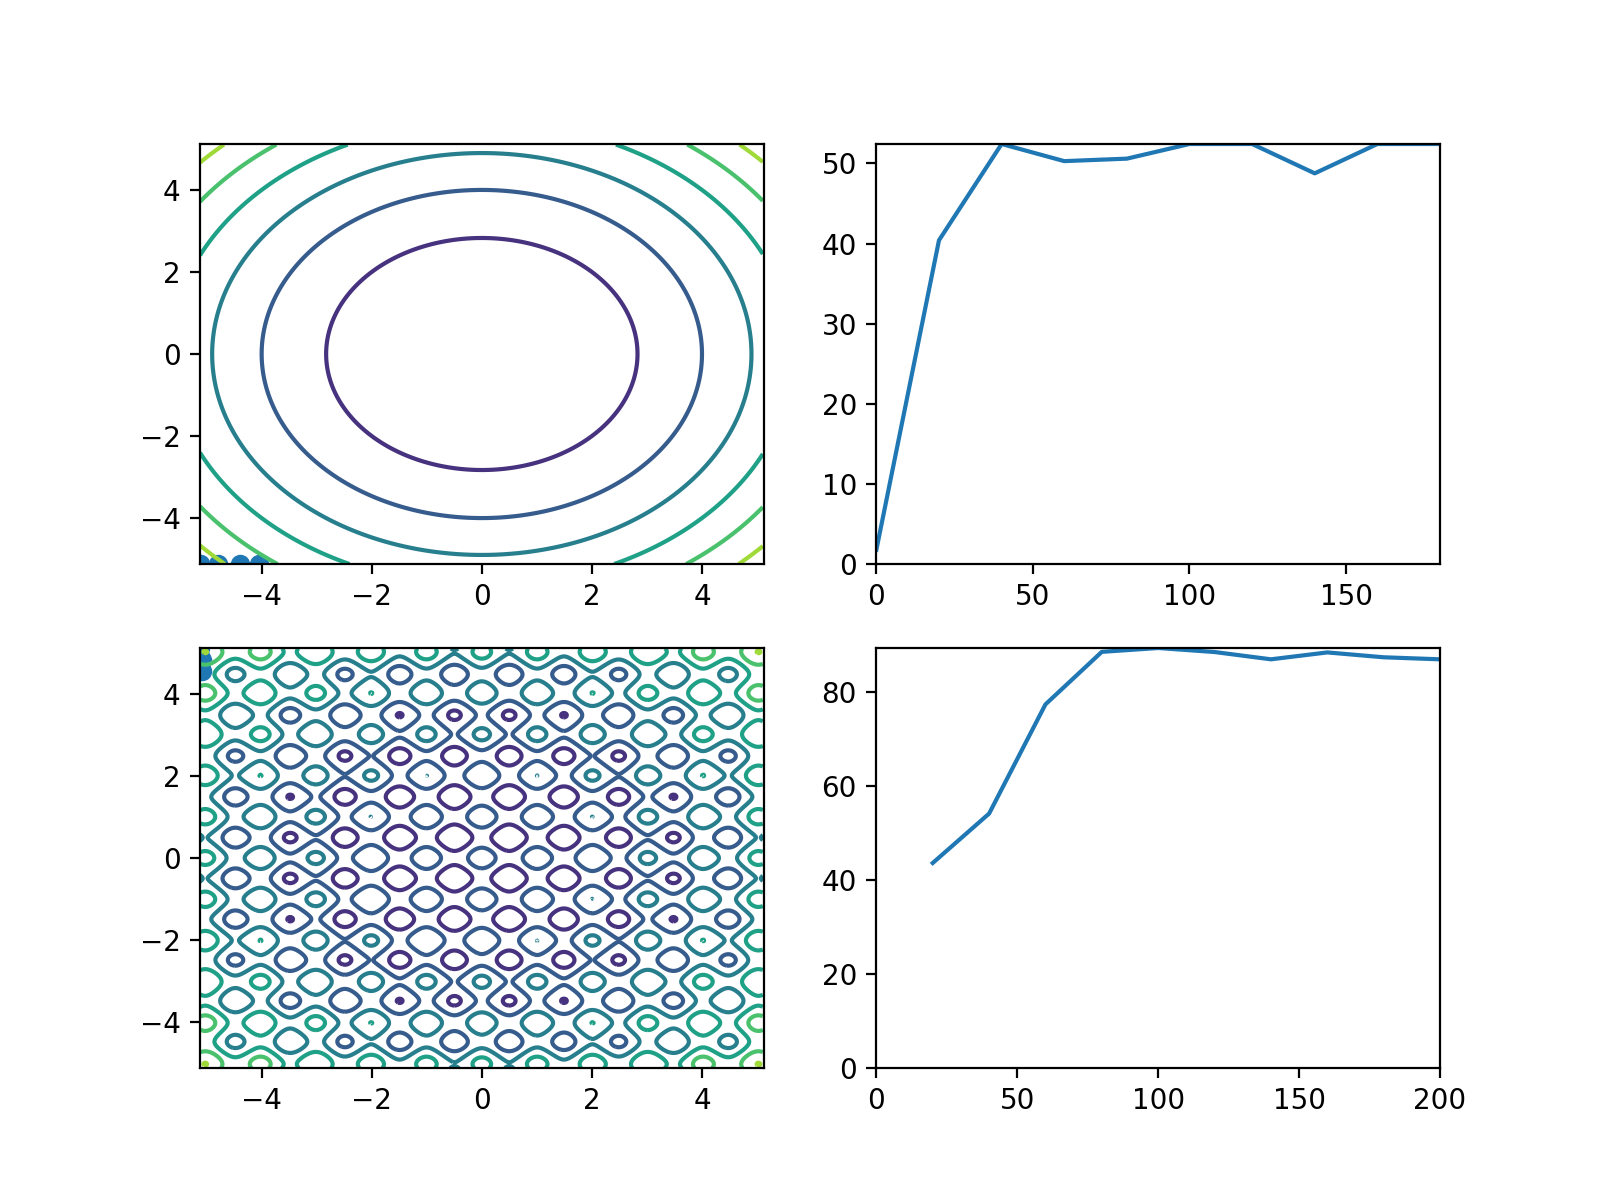

In [7]:
%matplotlib notebook
from leap.probe import PlotTrajectoryProbe, PopulationPlotProbe

def probe_plots(problems, modulo):
    """Create a figure with subplots for visualizing the population genotypes and best-of-gen 
    fitness for each problem.
    
    :return: two lists of probe operators (for the phenotypes and fitness, respectively). 
        Insert these into your algorithms to plot measurements to the respective subplots."""
    plt.figure(figsize=(8, 3*len(problems)))
    genotype_probes = []
    fitness_probes = []
    for i, p in enumerate(problems):
        plt.subplot(len(problems), 2, 2*i + 1)
        tp = PlotTrajectoryProbe(core.context, contours=p, xlim=p.bounds, ylim=p.bounds, granularity=0.025, modulo=modulo, ax=plt.gca())
        genotype_probes.append(tp)
        
        plt.subplot(len(problems), 2, 2*i + 2)
        fp = PopulationPlotProbe(core.context, ylim=(0, 1), modulo=modulo, ax=plt.gca())
        fitness_probes.append(fp)
        
    return genotype_probes, fitness_probes

genotype_probes, fitness_probes = probe_plots(problems, modulo=20)

Now I'll bundle up the probes for each problem into a list of separate `kwargs`:

In [8]:
problem_kwargs = [{'probes': [g, f] } 
                  for g, f in zip(genotype_probes, fitness_probes)]

#### Build

We're ready to build the repertoire.  You can think of this step like training a machine learner.  Scroll up to the plots above to see live telemetry during training!  The two training problems will run concurrently.

In [9]:
rep = PopulationSeedingRepertoire(random_init, ea,)
rep.build_repertoire(problems, problem_kwargs)

The resulting repertoire contains the best known individuals from each training problem:

In [10]:
rep.repertoire

[[-5.12, -5.12], [-5.050896175659292, 5.024616625837461]]

# Apply the Repertoire to a New Problem

Now let's setup a new problem (i.e. a "target" problem) to solve with the help of our trained repertoire:

In [11]:
problem3 = real_problems.StepProblem()

And some visuals, since I'm shallow like that:

<IPython.core.display.Javascript object>


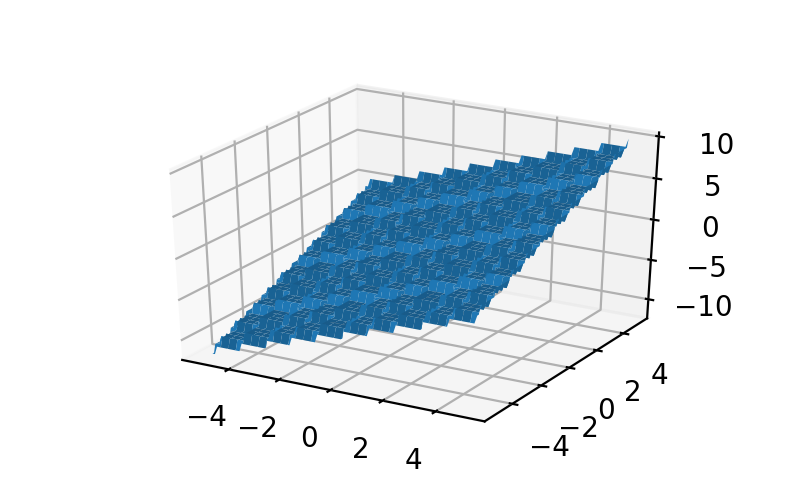

In [12]:
plt.figure(figsize=(4, 2.5))
plt.subplot(111, projection='3d')
real_problems.plot_2d_problem(problem3, ax=plt.gca(), xlim=problem3.bounds, ylim=problem3.bounds);

<IPython.core.display.Javascript object>


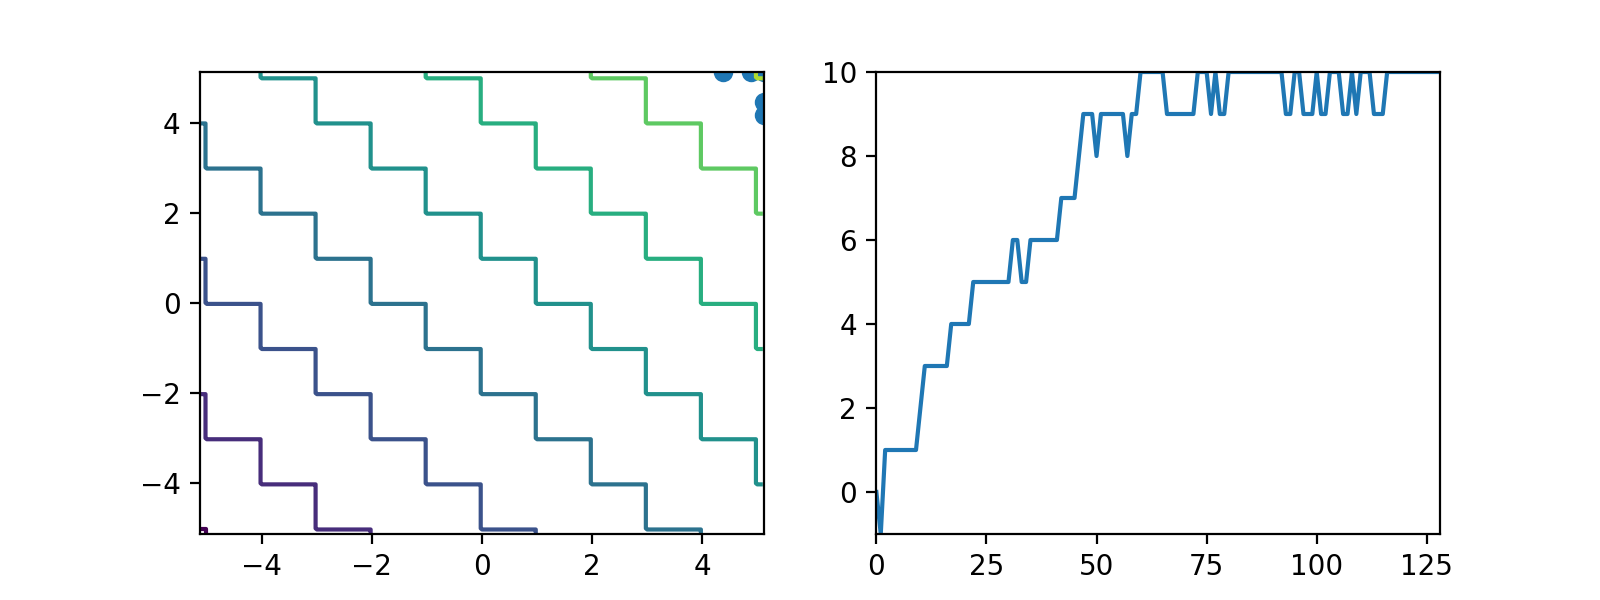

In [13]:
genotype_probes, fitness_probes = probe_plots([problem3], modulo=1)
genotype_probe = genotype_probes[0]
fitness_probe = fitness_probes[0]

In [14]:
result = rep.apply(problem3,
                   probes=[genotype_probe, fitness_probe])

In [15]:
# Rerun this cell if you want to step through the algorithm one frame at a time
next(result);

In [ ]:
# Run the rest at full speed
list(result);